使用GBRT算法建立Sepal.Length、Sepal.Width、Petal.Length对Petal.Width的回归模型。首先，建立函数gbrt_build，使用训练数据以构建GBRT模型

In [1]:
from sklearn import tree
import numpy as np

def gbrt_build(x,y,consame=5,maxiter=10000,shrinkage=0.0005):
    """
    建立函数构建GBRT模型
    x : 输入数据，解释变量
    y : 输出数据，响应变量
    consame : 当连续consame次得到的残差平方和相等时算法终止
    maxiter : 迭代次数的上限
    shrinkage : 缩放因子
    """
    # 使平方损失函数最小化的常数值为对应数据的平均值，即以均值初始化f0
    f0 = np.mean(y)
    #初始化变量
    rss = []
    model_list = [f0]
    # 进入循环，当连续consame次，得到的残差平方和相等或超过最大迭代次数时终止算法
    for i in range(maxiter):
        # 计算负梯度，当损失函数为平方损失函数时，负梯度即为残差
        revals = y - f0
        # 根据残差学习一棵回归树，设置分割点满足的最小样本量为 30
        clf = tree.DecisionTreeRegressor(min_samples_leaf=30)
        clf = clf.fit(x, revals)
        # 更新回归树，并生成估计结果
        model_list.append(clf)
        f0 = f0 + shrinkage*clf.predict(x)
        # 统计残差平方和
        rss.append(np.sum((f0 - y)**2))
        # 判断是否满足终止条件
        if len(rss) >= consame and np.std(rss[(len(rss)-consame+1):len(rss)]) == 0 :
            print("共迭代",m+1,"次，满足终止条件退出迭代！")
            break
    return rss,model_list

在使用iris数据建立GBRT模型之前，需要对其进行简单处理，然后调用函数gbrt_build，完成模型的训练

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
iris = pd.read_csv("http://image.cador.cn/data/iris.csv")
x,y = iris.drop(columns=['Species','Petal.Width']),iris['Petal.Width']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
rss,model_list = gbrt_build(x_train,y_train)

#查看rss的统计信息
pd.Series(rss).describe()

count    10000.000000
mean         9.443136
std         11.613604
min          2.954312
25%          3.230344
50%          3.919855
75%          9.398138
max         59.853140
dtype: float64

为进一步直观呈现每次迭代残差平方和的变化，现绘制二维图形

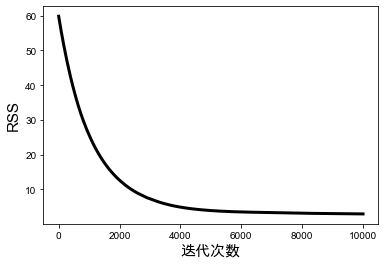

In [3]:
#根据rss绘制曲线，以直观观察残差平方和的变化趋势
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'
plt.plot(range(10000),rss[0:10000],'-',c='black',linewidth=3)
plt.xlabel("迭代次数",fontsize=15)
plt.ylabel("RSS",fontsize=15)
plt.show()

现使用Python实现预测函数gbrt_predict，即可对新数据进行预测

In [4]:
def gbrt_predict(x,gml_list,shrinkage):
    """
    建立预测函数，对新数据进行预测
    x : 进行预测的新数据
    gml_list : 即GBRT的模型列表
    shrinkage : 训练模型时，指定的shrinkage参数
    """
    f0 = gml_list[0]
    for i in range(1,len(gml_list)):
        f0 = f0 + shrinkage*gml_list[i].predict(x)
    return f0

对测试数据集x_test，调用预测函数gbrt_predict，根据预测结果和真实结果，分析预测效果

In [5]:
np.sum((y_test - gbrt_predict(x_test,model_list,0.0005))**2)

1.3384897597030645

为说明该方法对预测建模提升的效果，现直接使用回归决策树基于训练集x_train,y_train建模，并对测试数据集x_test进行预测，同时分析预测效果

In [6]:
clf = tree.DecisionTreeRegressor(min_samples_leaf=30)
clf = clf.fit(x_train, y_train)
np.sum((y_test - clf.predict(x_test))**2)

1.5676935145052517